In [485]:
# the notebook shlould be run inside the slp enviroment which has 
# all the neccessera libraries except the following ones:

import pyarrow.parquet as pq
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from datetime import datetime, timedelta

In [612]:
# const

lice_stages_to_names = {
    "L4":"PA",
    "L5m":"AM",
    "L5f":"AF",
    "all":"Sum"
}

After approval this notebook will be converted to a script which will be run with arguments indicating witch plots to produce and an input directory. It will then create an output directory containing a .png's of desired plots

Questions:
- What counts in the overall lice count? - yes, L1 to L5m
- what about the sea temperature (the double y axis...), also where to find the data - in the folder about the lochs
- talk about how exactly treatments work and how long shoul they be highlighted

Notes:
- is it a high quality code... no - the pandas queries can be definitely more efficient, but it works fast, so maybe refactoring if there is more time in the future..
- could add the cleaner fish count or maybe cleaner fish to salmon ration somehow? maybe use the extra y axes for that sing it would look weird on the log scale...

Todo:
- change fonts in legend (not sure if they work properly now..)
- deal somehow with the "730" days constant in the code
- better math bor calclualting the 5 and 95 % index

In [ ]:
    # todo
    def initialise_temperatures(self, temperatures: Dict[str, LocationTemps]) -> np.ndarray:
        """
        Calculate the mean sea temperature at the northing coordinate of the farm at
        month c_month interpolating data taken from
        www.seatemperature.org
        """

        # TODO: move this in a separate file, e.g. Lake? See #96
        ardrishaig_data = temperatures["ardrishaig"]
        ardrishaig_temps, ardrishaig_northing = np.array(ardrishaig_data["temperatures"]), ardrishaig_data["northing"]
        tarbert_data = temperatures["tarbert"]
        tarbert_temps, tarbert_northing = np.array(tarbert_data["temperatures"]), tarbert_data["northing"]

        degs = (tarbert_temps - ardrishaig_temps) / abs(tarbert_northing - ardrishaig_northing)

        Ndiff = self.loc_y - tarbert_northing
        return np.round(tarbert_temps - Ndiff * degs, 1)
    
    
if TYPE_CHECKING:
    from ..simulation.cage import Cage


class Treatment(Enum):
    """
    A stub for treatment types
    """

    EMB = 0
    THERMOLICER = 1
    CLEANERFISH = 2


TREATMENT_NO = len(Treatment)


def treatment_to_class(treatment: Treatment):
    """
    Get the right treatment class


different kinds of plts in this document

### Lice count
**done** - 1 farm all the trials plot \
**done** - 1 farm one trial all the treatments \
all farms aggregated data

### Genotypes
genetotypes one farm all trials \
genetotypes all trials aggregated data

### Site map
one loch the movements on eggs \
one loch movements of eggs sankey diagram...

fish population and treatments - daily

payoff plot

comparison between bernouli and mosaic at one plot
the envelope plot - violin plot, the confidence interval and payoff - seaborn

Maybe :
- lice per fish
- cleaner fish ratio
- expernal pressure
- genetotypes one trial all farm - my visualisation
- genetorype one trial one farm - my visualisation

## Lice count plots

There are 3 types of lice count plots:
- 1 farm one trial (including the treatments)
- 1 farm all the trials
- all farm aggregated data

The plots can of course contain different lice stages if wanted...

In [613]:
# data prep

def load_data(dir_name, num_of_trials):
    parquet_files = []
    for file in os.listdir("./" + dir_name):
        if file.endswith(".parquet"):
            parquet_files.append(os.path.join("./" + dir_name, file))
        else:
            if file.endswith(".pickle"):
                pickle_file = os.path.join("./" + dir_name, file)
    return parquet_files[:num_of_trials], pickle_file

#### 1 farm one trial (including the treatments)

- todo try shading lines on treatments

In [614]:
def get_agg_lice_counts(table, lice_stages, farm_id):
    lice_counts_stages = []
    for stage in lice_stages:
        if stage == "all":
            lice_counts_stages.append(np.array(list(map(np.array, list(table.loc[table.farm_name == 'farm_' + str(farm_id)].apply(lambda row: (row.timestamp, sum([sum(row[x].values()) for x in ["L1", "L2", "L3", "L4", "L5m", "L5f"]])), axis=1))))))
        else:
            lice_counts_stages.append(np.array(list(map(np.array, list(table.loc[table.farm_name == 'farm_' + str(farm_id)].apply(lambda row: (row.timestamp, sum(row[stage].values())), axis=1))))))
    return lice_counts_stages

def get_treatment_data(table, farm_id):
    return table.loc[table.farm_name=="farm_"+str(farm_id)].loc[table.loc[table.farm_name=="farm_"+str(farm_id)].apply(lambda row: sum(row["current_treatments"])!=0, axis=1)][["timestamp", "current_treatments"]]

def is_cleanerfish(x):
    a, b = x
    if a==0 and b!=0:
        return True
    return False

def get_cleaner_fish_stock_dates(table, farm_id):
    table["stock_cleaner_fish"] = table.loc[table.farm_name=="farm_"+str(farm_id)].cleaner_fish.rolling(2).apply(is_cleanerfish)
    return list(table.loc[table.stock_cleaner_fish == 1].timestamp)

def one_farm_one_trial_data_prep(pqt_name, pkl_name, farm_id, stages_to_plot):
    table = pq.read_table("./" + pqt_name).to_pandas()
   
    with open("./" + pkl_name, 'rb') as f:
        farms_data = pickle.load(f)
    farm_name = farms_data.farms[farm_id].name
    
    return get_agg_lice_counts(table, stages_to_plot, farm_id), get_treatment_data(table, farm_id), get_cleaner_fish_stock_dates(table, farm_id), farm_name

In [615]:
# example input 

stages_to_plot = ["all", "L4", "L5m", "L5f"]

pqt_list, pkl_name = load_data("Fyne_complete_bernoulli_1.0", 1)

lice_stages_count, treatments, cleaner_fish_dates, farm_name = one_farm_one_trial_data_prep(pqt_list[0], pkl_name, 0, stages_to_plot)

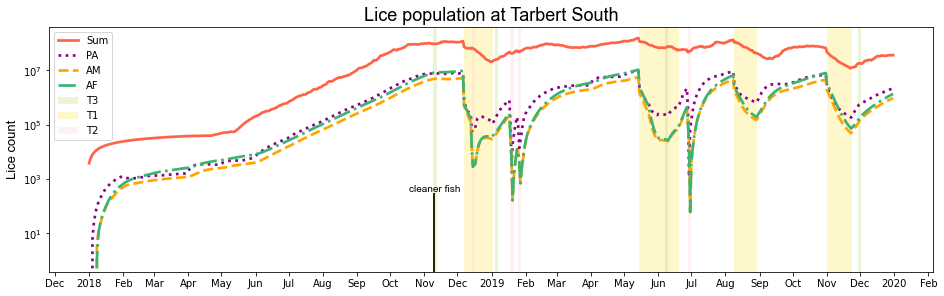

In [619]:
# plot set up
linestyles = ["solid", "dotted", "dashed", "dashdot", "solid", "dotted", "dashed", "dashdot"]
colors = ["tomato", "darkmagenta", "orange", "mediumseagreen", "skyblue"]
linewidth = 2.7
hfont = {'fontname':'Arial'}

# creating the plot

fig, ax = plt.subplots(figsize=(13, 4), constrained_layout=True)

for i, lice_counts in enumerate(lice_stages_count):
    ax.plot(lice_counts[:, 0], lice_counts[:, 1], label = lice_stages_to_names[stages_to_plot[i]], linestyle=linestyles[i], color=colors[i], linewidth=linewidth)

for date in cleaner_fish_dates:
    ax.bar(date, 300, 2, color = "black")
    plt.text(date, 302, "cleaner fish", ha='center', va='bottom', **hfont)
    
label1, label2, label3, label4 = [True]*4
for _, row in treatments.iterrows():
    if row.current_treatments[0] == 1:
        #ax.bar(row.timestamp, 1000, 2, color = "lemonchiffon")
        ax.axvspan(row.timestamp, row.timestamp+timedelta(days=1), facecolor='gold', alpha=0.20, label='T1' if label1 else '')
        label1 = False
    if row.current_treatments[1] == 1:
        ax.axvspan(row.timestamp, row.timestamp+timedelta(days=1), facecolor='lightpink', alpha=0.20, label='T2' if label2 else '')
        label2 = False
    if row.current_treatments[2] == 1:
        ax.axvspan(row.timestamp, row.timestamp+timedelta(days=1), facecolor='yellowgreen', alpha=0.20, label='T3' if label3 else '')
        label3 = False
    if row.current_treatments[3] == 1:
        ax.axvspan(row.timestamp, row.timestamp+timedelta(days=1), facecolor='g', alpha=0.20, label='T4' if label4 else '')
        label4 = False

# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(False)
ax.set_ylabel(r'Lice count', fontsize=13, **hfont)
ax.set_yscale('log')

# ax.set_title('ConciseFormatter', loc='left', y=0.85, x=0.02, fontsize='medium')
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Adding Twin Axes (in progress if we need it)
# ax2 = ax.twinx()
# color = 'tab:green'
# ax2.set_ylabel('Y2-axis', color = color)
# ax2.plot(l4_data[:, 0], l5m_data[:, 0], color = color)
# ax2.tick_params(axis ='y', labelcolor = color)

plt.legend()
plt.title('Lice population at ' + farm_name, fontsize=18, **hfont)
plt.show()

#### 1 farm all (1000) trials

- todo add all lice
- change the lables to biologically accepteble
- parametrise num of runs
- put somehow the CI in the legend

- shading effects?

In [603]:
def one_farm_all_trials_prep(pqt_list, pkl_name, farm_id):
    l = []
    for pqt_name in pqt_list:
        table = pq.read_table("./" + pqt_name).to_pandas()
        if table.loc[table.farm_name == "farm_" + str(farm_id)].shape[0] == 730:
            l.append(np.array(list(map(np.array, list(table.loc[table.farm_name == 'farm_' + str(farm_id)].apply(lambda row: (row.timestamp, sum(row["L1"].values()), sum(row["L2"].values()), sum(row["L3"].values()), sum(row["L4"].values()), sum(row["L5m"].values()), sum(row["L5f"].values())), axis=1))))))
        
    with open("./" + pkl_name, 'rb') as f:
        farms_data = pickle.load(f)
    farm_name = farms_data.farms[farm_id].name
    
    return np.array(l), farm_name

def getting_bounds(lice_stages_counts):
    p5 = int(len(lice_stages_counts)/20)
    med = int(len(lice_stages_counts)/2)
    p95 = int(len(lice_stages_counts)*95/100)
    x = lice_stages_counts[0][:, 0]
    y = []
    y_u = []
    y_l= []
    for j in range(lice_stages_counts[0].shape[1]-1):
        y.append([])
        y_u.append([])
        y_l.append([])
        for i in range(730):
            sort_val_trials = sorted(np.array(lice_stages_counts)[:, i, j+1])
            y[j].append(sort_val_trials[med])
            y_u[j].append(sort_val_trials[p95])
            y_l[j].append(sort_val_trials[p5])
    return x, y, y_u, y_l

In [604]:
%timeit

pqt_list, pkl_name = load_data("Fyne_complete_bernoulli_1.0", 1000)

lice_stages_counts, farm_name = one_farm_all_trials_prep(pqt_list, pkl_name, 0)
x, y, y_u, y_l = getting_bounds(lice_stages_counts)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.11 µs


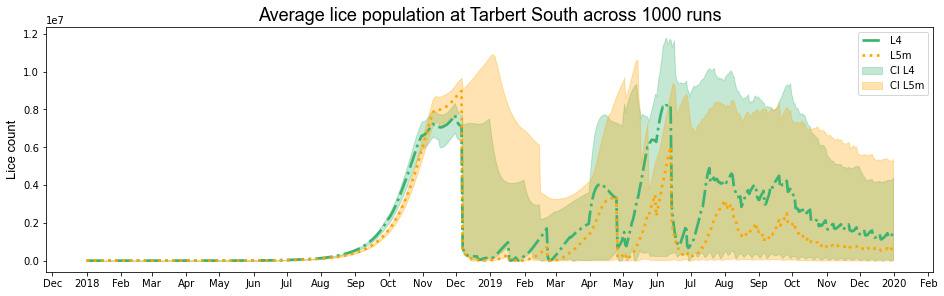

In [629]:
# plot set up
linestyles = ["solid", "dotted", "dashed", "dashdot", "solid", "dotted", "dashed", "dashdot"]
colors = ["tomato", "darkmagenta", "tomato", "mediumseagreen", "skyblue", "orange"]
linewidth = 2.7
hfont = {'fontname':'Arial'}

# creating the plot

fig, ax = plt.subplots(figsize=(13, 4), constrained_layout=True)

labels = ["L1", "L2", "L3", "L4", "L5f", "L5m"]
for i in [3, 5]:
    ax.plot(x, y[i], label = labels[i], linestyle=linestyles[i], color=colors[i], linewidth=linewidth)
    ax.fill_between(x, y_l[i], y_u[i], alpha=0.3, edgecolor=colors[i], facecolor=colors[i], label="CI "+labels[i])

# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(False)
ax.set_ylabel(r'Lice count', fontsize=13, **hfont)
#ax.set_yscale('log')

# ax.set_title('ConciseFormatter', loc='left', y=0.85, x=0.02, fontsize='medium')
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Adding Twin Axes (in progress if we need it)
# ax2 = ax.twinx()
# color = 'tab:green'
# ax2.set_ylabel('Y2-axis', color = color)
# ax2.plot(l4_data[:, 0], l5m_data[:, 0], color = color)
# ax2.tick_params(axis ='y', labelcolor = color)

plt.legend()
plt.title('Average lice population at ' + farm_name + " across 1000 runs", fontsize=18, **hfont)
plt.show()

#### all farm all trials

- todo add all lice

In [607]:
def all_farms_all_trials_prep(pqt_list):
    l = []
    for pqt_name in pqt_list:
        table = pq.read_table("./" + pqt_name).to_pandas()
        if table.loc[table.farm_name == "farm_"0].shape[0] == 730:
            l.append(np.array(list(map(np.array, list(table.loc[table.farm_name == 'farm_' + str(farm_id)].apply(lambda row: (row.timestamp, sum(row["L1"].values()), sum(row["L2"].values()), sum(row["L3"].values()), sum(row["L4"].values()), sum(row["L5m"].values()), sum(row["L5f"].values())), axis=1))))))

    
    return np.array(l), farm_name

def getting_bounds(lice_stages_counts):
    p5 = int(len(lice_stages_counts)/20)
    med = int(len(lice_stages_counts)/2)
    p95 = int(len(lice_stages_counts)*95/100)
    x = lice_stages_counts[0][:, 0]
    y = []
    y_u = []
    y_l= []
    for j in range(lice_stages_counts[0].shape[1]-1):
        y.append([])
        y_u.append([])
        y_l.append([])
        for i in range(730):
            sort_val_trials = sorted(np.array(lice_stages_counts)[:, i, j+1])
            y[j].append(sort_val_trials[med])
            y_u[j].append(sort_val_trials[p95])
            y_l[j].append(sort_val_trials[p5])
    return x, y, y_u, y_l

[3, 4, 5]

In [609]:
%timeit

pqt_list, pkl_name = load_data("Fyne_complete_bernoulli_1.0", 1000)

lice_stages_counts, farm_name = all_farms_all_trials_prep(pqt_list)
x, y, y_u, y_l = getting_bounds(lice_stages_counts)

6

## Genotype plots

- genetotypes one farm all trials
- genetotypes all trials aggregated data

In [ ]:
def plot_geno(cfg, axs, ax_idx, xs, output_folder):
    stages = tuple(LicePopulation.lice_stages)
    alleles = geno_to_alleles(0)

    lice_pop = get_lice_pop(cfg, output_folder, stages)

    def agg(x, allele):
        return x[allele]

    per_allele_pop = {
        allele: load_matrix(
            cfg,
            output_folder,
            stages,
            preprocess=np.vectorize(lambda x: agg(x, allele=allele)),
            ci=False
        ) for allele in alleles
    }

    for i in range(cfg.nfarms):
        farm_name = f"farm_{i}"
        for allele in alleles:
            per_allele_pop_farm = per_allele_pop[allele][farm_name]
            lice_pop_farm = lice_pop[farm_name]
            normalised = sum(per_allele_pop_farm[stage] for stage in stages) / (
                sum(lice_pop_farm[stage] for stage in stages)
            )
            geno_ax = axs[farm_name][1][ax_idx]
            ribbon_plot(geno_ax, xs, get_ci(normalised), allele)
            prepare_ax(geno_ax, "By geno", legend=True, yscale="linear", ylim=(0, 1))

In [ ]:
# Geopandas and a map

In [169]:
import geopandas
import contextily as cx

In [213]:
with open('config_Fyne_complete_bernoulli_1.0b90996a0d1a23287d6a9802d30cda534cfd815ba419fd90911a15a2564796427.pickle', 'rb') as f:
    misc = pickle.load(f)

In [264]:
farm_names = []
lat = []
long = []
for farm in misc.farms:
    farm_names.append(farm.name)
    lat.append(farm.farm_location[0]/10000)
    long.append(farm.farm_location[1]/10000)

In [265]:
long

[66.53, 66.82, 66.95, 67.45, 67.68, 67.96, 68.1, 69.22, 69.8]

In [266]:
lat

[19.03, 19.25, 19.18, 18.65, 19.04, 18.63, 19.08, 19.53, 19.98]

/usr/local/Caskroom/miniconda/base/envs/slp/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


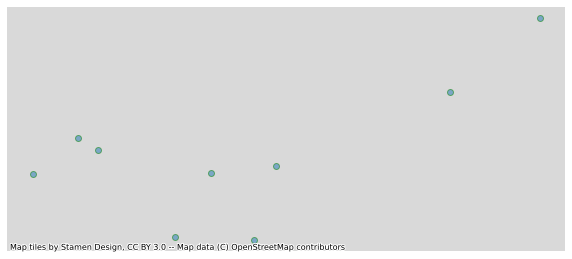

In [297]:
from matplotlib.patches import FancyArrowPatch, ArrowStyle

df = pd.DataFrame({
    'LAT'  :lat,
    'LONG' :long,
})
df['coords'] = list(zip(df.LONG, df.LAT))

geo_df = gpd.GeoDataFrame(
    df, crs  ={'init': 'epsg:4326'},
    geometry = df['coords'].apply(Point)
).to_crs(epsg=3857)

df_wm = geo_df.to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 20), alpha=0.5, edgecolor='g')

style = ArrowStyle('Fancy', head_length=1, head_width=1.5, tail_width=0.5)
arrow = FancyArrowPatch((19.03, 66.53), (19.25, 66.82), mutation_scale=25, arrowstyle=style, color='g')                     
ax.add_patch(arrow)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

plt.show()

In [ ]:
style = ArrowStyle('Fancy', head_length=1, head_width=1.5, tail_width=0.5)
arrow = FancyArrowPatch((19.03, 66.53), (19.25, 66.82), mutation_scale=25, arrowstyle=style, color='g')                     
ax.add_patch(arrow)

(-0.1, 1.1)

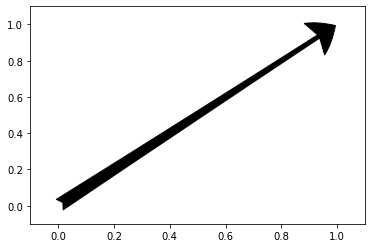

In [242]:
from matplotlib.patches import FancyArrowPatch, ArrowStyle

fig, ax = plt.subplots()
style = ArrowStyle('Fancy', head_length=1, head_width=1.5, tail_width=0.5)
arrow = FancyArrowPatch((0, 0), (1, 1), mutation_scale=25, arrowstyle=style, color='k')                     
ax.add_patch(arrow)

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

/usr/local/Caskroom/miniconda/base/envs/slp/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


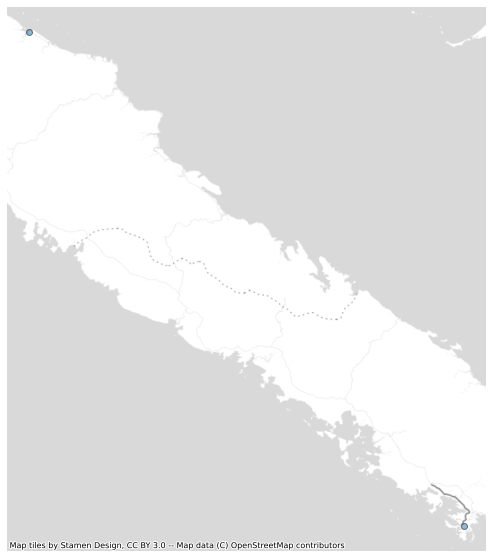

In [212]:
df = pd.DataFrame({
    'LAT'  :[-22.266415, -20.684157],
    'LONG' :[166.452764, 164.956089],
})
df['coords'] = list(zip(df.LONG, df.LAT))

# ... turn them into geodataframe, and convert our
# epsg into 3857, since web map tiles are typically
# provided as such.
geo_df = gpd.GeoDataFrame(
    df, crs  ={'init': 'epsg:4326'},
    geometry = df['coords'].apply(Point)
).to_crs(epsg=3857)

df_wm = geo_df.to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()


# plt.title('Kaledonia : From Hienghène to Nouméa')
# plt.show()

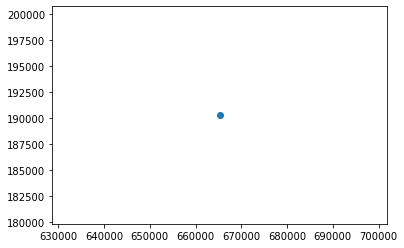

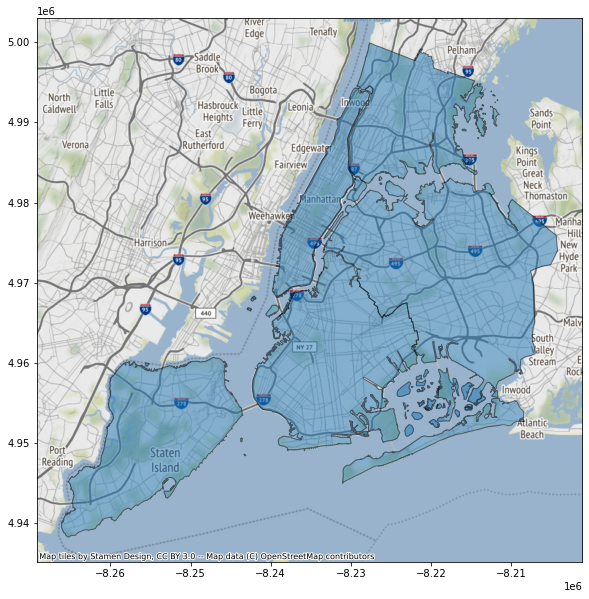

In [190]:
ax = plt.axes()
ax.scatter(x.farms[0].farm_location[1], x.farms[0].farm_location[0])
df_wm = df.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

In [ ]:
# test with basemaps

In [307]:
# libraries
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

# Set the plot size for this notebook:
plt.rcParams["figure.figsize"]=15,12

# A basic map
m=Basemap(llcrnrlon=-100, llcrnrlat=20, urcrnrlon=30, urcrnrlat=70, projection='merc')
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white");

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [306]:
pip install basemap --no-binary :all:

  Using cached basemap-1.3.3.zip (155 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 30.5 MB 10.6 MB/s eta 0:00:01   |███▏                            | 3.0 MB 3.6 MB/s eta 0:00:08     |█████████▏                      | 8.7 MB 8.4 MB/s eta 0:00:03     |██████████▋                     | 10.1 MB 8.4 MB/s eta 0:00:03
  Using cached pyshp-2.1.3.tar.gz (219 kB)
     |████████████████████████████████| 11.5 MB 8.5 MB/s eta 0:00:01    |██████▎                         | 2.2 MB 6.5 MB/s eta 0:00:02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Skipping wheel build for basemap-data, due to binaries being disabled for it.
Skipping wheel build for pyshp, due to binaries being disabled for it.
  ERROR: Command errored out with exit status 1:
   command: /usr/local/Caskroom/miniconda/base/envs/slp/bin/